In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from IPython.display import clear_output

format = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    transforms.RandomCrop((400, 400)),
    transforms.RandomRotation(180),

    transforms.CenterCrop((282, 282)), # 282 ~= 400 * (1/sqrt(2))
    transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST),

    transforms.RandomApply(p=0.2, transforms=[transforms.GaussianBlur(5, sigma=(.5, 12))]),
    transforms.RandomApply(p=0.2, transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.5)]),

    transforms.ToTensor(),
])
ds = datasets.Flowers102(root='../pytorch-datasets/', split='train', transform=format, download=True)
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

In [2]:
def random_1d_slice(batch, num_samples):
    b, c, h, w = batch.shape
    lines = []
    points = []

    for img in batch:
        x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
        x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
        x = torch.linspace(x1, x2, num_samples, dtype=torch.int)
        y = torch.linspace(y1, y2, num_samples, dtype=torch.int)

        img_lines = []
        for channel in img:
            img_lines.append(channel[y, x])
            
        points.append(torch.stack([x, y]))
        lines.append(torch.stack(img_lines))

    return torch.stack(lines), torch.stack(points)

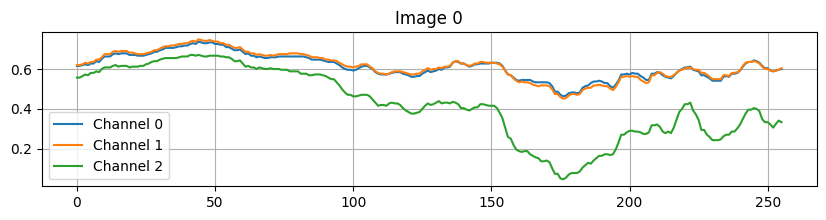

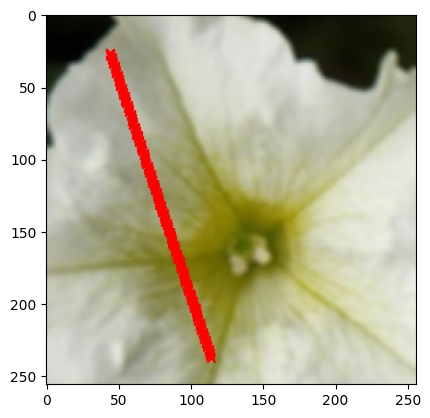

In [27]:
NUM_SAMPLES = 256
batch, labels = next(iter(dl))
random_lines, points = random_1d_slice(batch, NUM_SAMPLES)

# Plot the lines
for i, img_lines in enumerate(random_lines):
    plt.figure(figsize=(10, 2))
    for j, line in enumerate(img_lines):
        plt.plot(line.numpy(), label=f'Channel {j}')
    plt.grid(True)
    plt.title(f'Image {i}')
    plt.legend()
    plt.show()
    plt.imshow(batch[i].permute(1, 2, 0))
    plt.scatter(points[i][0], points[i][1], c='red', marker='x')
    plt.show()
    break

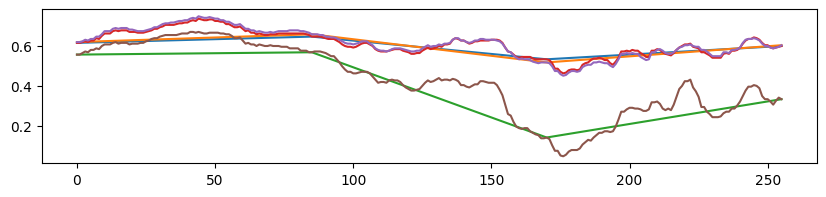

(torch.Size([64, 3, 4]),
 array([  0.,  17.,  34.,  51.,  68.,  85., 102., 119., 136., 153., 170.,
        187., 204., 221., 238., 255.]))

In [75]:
key = F.interpolate(random_lines, scale_factor=1/64, mode='linear', align_corners=True)
plt.figure(figsize=(10, 2))
plt.plot(np.linspace(0, NUM_SAMPLES-1, 256//64), key[0,:,:].permute(1, 0).numpy())
plt.plot(random_lines[0,:,:].permute(1, 0).numpy())
plt.show()
key.shape, np.linspace(0, NUM_SAMPLES-1, 16)